In [23]:
from scipy.optimize import curve_fit
import numpy as np
from scipy import integrate
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu, BlackBody1D
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

%matplotlib inline
SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Zero points (photon flux)

In [24]:
# photon fluxes per m**2 / s / micron for typical filters
v_fl = 9.6e10 
z_fl = 4e10
y_fl = 3e10
j_fl = 2.02e10
jp_fl = 2.02e10
h_fl = 9.56e9
k_fl = 4.66e9

## HISPEC APIC specs (H2RG)

In [63]:
area = 76.0#Keck telescope area in m**2
diam = 10.

dc = 0.05#e-/pix/s
ron = 10.#e- per read
samp = 3**2 # 3x3 pixels per resel
sat=1e5/2#Linearity is half of full well depth

bw = 0.15# typical filter bandwidth (conservative)
th = 0.12# Optical throughput to APIC (out of band, source: G. Ruane's throughput budget)

mag = np.linspace(0,20,21)
mag_fine = np.linspace(0,20,201)

tmax = 30.# maximum exposure time for drift compensation

k_wv = 2200. #nm
h_wv = 1650.
j_wv = 1250.
y_wv = 1000.
t2_wv = 1400.

## HAKA WFE budget

In [82]:
aowfe_ngs=np.array([133,134,134,134,135,137,140,144,153,162,182,209,253,311,398,510,671,960,1446,2238,3505])
aowfe_lgs=np.array([229,229,229,229,229,229,230,230,231,231,232,235,238,247,255,281,301,345,434,601,889])

#Typical WFE budget (source: P. Wizinowich's various HAKA-like WFE budget)

## HAKA (visible SH WFS) - K band

In [83]:
f_ngs = interp1d(mag,aowfe_ngs,kind='cubic')
f_lgs = interp1d(mag,aowfe_lgs,kind='cubic')

aowfe_ngs_interp=f_ngs(mag_fine)
aowfe_lgs_interp=f_lgs(mag_fine)

res = np.zeros(len(mag_fine))
t_10sigma =  np.zeros(len(mag_fine))
eff_tt =  np.zeros(len(mag_fine))
eff =  np.zeros(len(mag_fine))

for i in range(len(mag_fine)):
    aowfe_interp = np.min([aowfe_ngs_interp[i],aowfe_lgs_interp[i]])
    strehl = np.exp(-(2*np.pi*aowfe_interp/k_wv)**2)
    strehl_t2 = np.exp(-(2*np.pi*aowfe_interp/t2_wv)**2)
    flux = h_fl * th * area * bw * strehl_t2 * 10**(-0.4*mag_fine[i])
    dc_tot_flux = dc * samp 
    fps = np.max([(flux/samp + dc_tot_flux/samp)/sat,1/tmax])
    t = 1.0/fps
    print('fps',fps, 'tint',t)
    signal = flux * t
    dc_tot = dc_tot_flux * t
    ron_tot = samp * ron**2 
    noise = np.sqrt(signal + dc_tot + ron_tot)
    res[i] = t2_wv * 1e-9/diam * 206265 * 1.0/strehl_t2**0.25 / (signal / noise)
    eff_tt[i] = np.exp(-(res[i]/(0.6*k_wv * 1e-9/diam* 206265))**2)
    eff[i]=strehl*0.65*1.3
#     t_10sigma[i] = 30.**2 *(flux + dc_tot_flux + ron_tot_flux)/flux**2



fps 20351.457351551 tint 4.9136530260511754e-05
fps 18543.727536101924 tint 5.392659043620795e-05
fps 16898.20723103468 tint 5.917787528155256e-05
fps 15400.126976402273 tint 6.493452953552314e-05
fps 14036.086212365422 tint 7.124493144812878e-05
fps 12793.923967590614 tint 7.816210277106428e-05
fps 11662.601984099687 tint 8.574415909617417e-05
fps 10632.099065071172 tint 9.405480459500459e-05
fps 9693.315551527146 tint 0.00010316387562999057
fps 8837.986941517447 tint 0.00011314793816931167
fps 8058.6057624775385 tint 0.0001240909444480083
fps 7348.35089492349 tint 0.00013608495488298423
fps 6701.0236244939115 tint 0.00014923093187505724
fps 6110.989770402525 tint 0.00016363961282398463
fps 5573.127302392688 tint 0.00017943247044988083
fps 5082.778915979267 tint 0.00019674276936504058
fps 4635.709087749039 tint 0.00021571672878324856
fps 4228.065179333116 tint 0.00023651480229964854
fps 3856.342200873124 tint 0.0002593130868348736
fps 3517.3508828362833 tint 0.00028430487412550406
fps

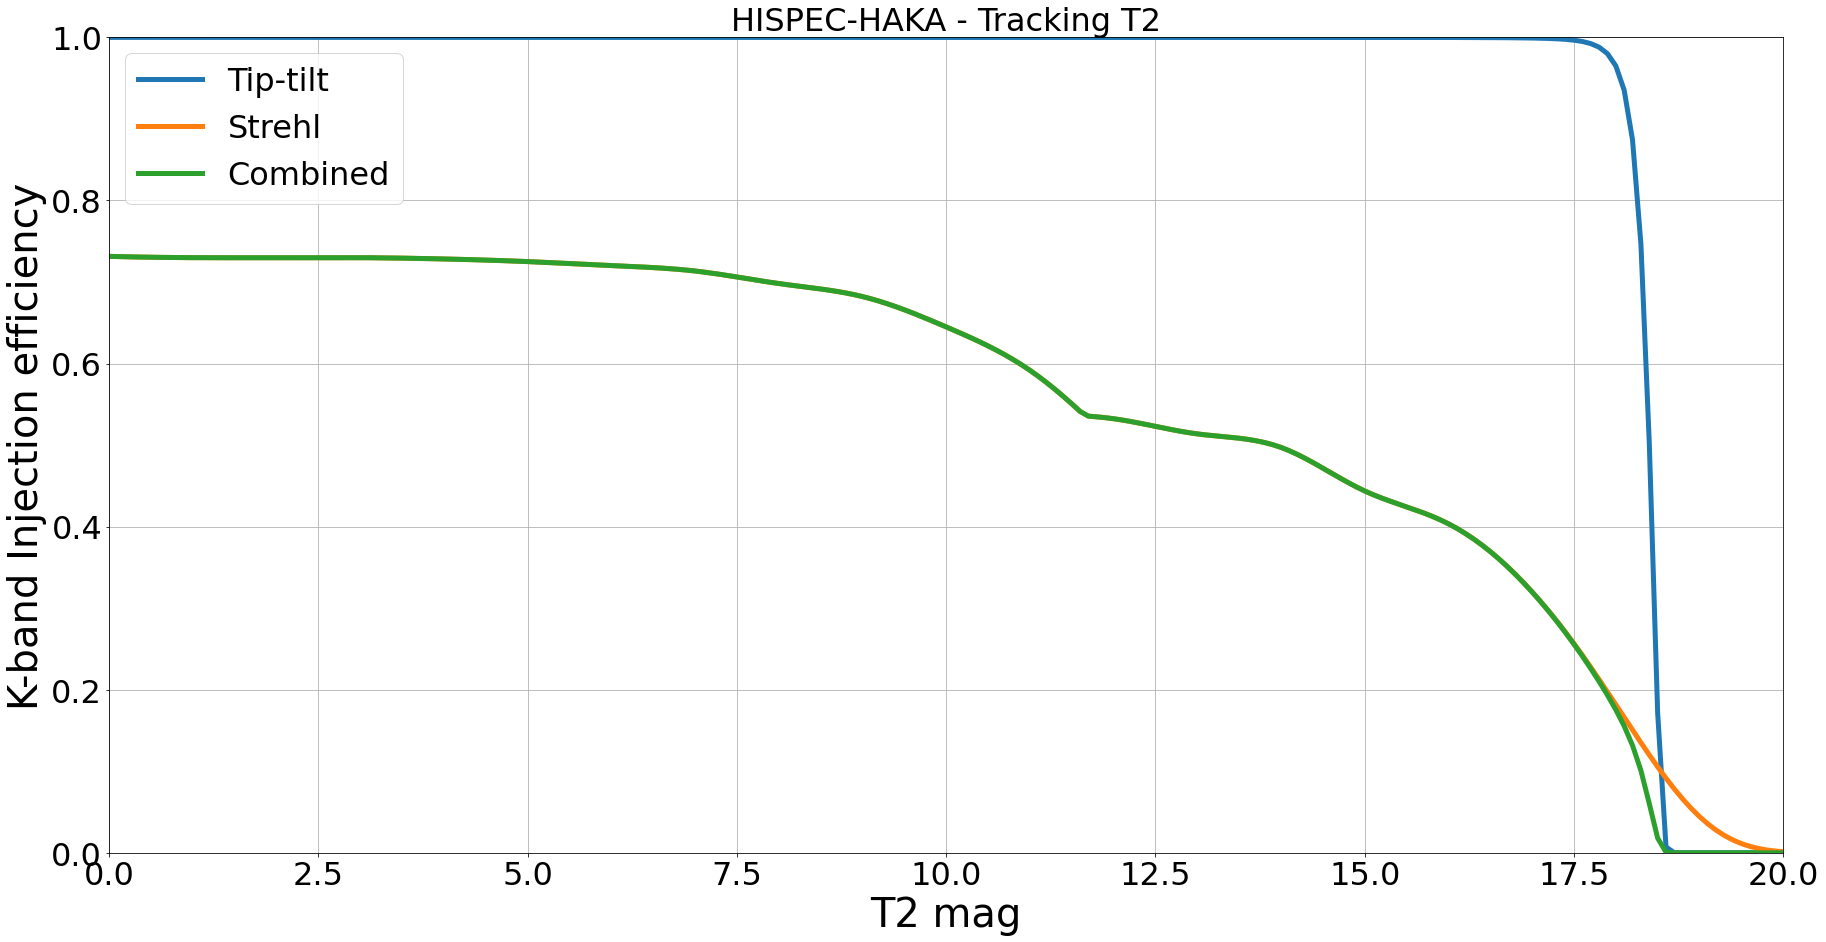

In [84]:
plt.figure(figsize=(30,15))
plt.plot(mag_fine, eff_tt, linewidth=5, label='Tip-tilt')
plt.plot(mag_fine, eff, linewidth=5, label='Strehl')
plt.plot(mag_fine, eff*eff_tt, linewidth=5, label='Combined')

plt.xlabel('T2 mag')
plt.ylabel('K-band Injection efficiency')
plt.title('HISPEC-HAKA - Tracking T2')
plt.legend()

plt.ylim([0,1])
plt.xlim([0,20])
plt.grid()

## HAKA (visible SH WFS) - H band

In [85]:
f_ngs = interp1d(mag,aowfe_ngs,kind='cubic')
f_lgs = interp1d(mag,aowfe_lgs,kind='cubic')

aowfe_ngs_interp=f_ngs(mag_fine)
aowfe_lgs_interp=f_lgs(mag_fine)

res = np.zeros(len(mag_fine))
t_10sigma =  np.zeros(len(mag_fine))
eff_tt =  np.zeros(len(mag_fine))
eff =  np.zeros(len(mag_fine))

for i in range(len(mag_fine)):
    aowfe_interp = np.min([aowfe_ngs_interp[i],aowfe_lgs_interp[i]])
    strehl = np.exp(-(2*np.pi*aowfe_interp/h_wv)**2)
    strehl_t2 = np.exp(-(2*np.pi*aowfe_interp/t2_wv)**2)
    flux = h_fl * th * area * bw * strehl_t2 * 10**(-0.4*mag_fine[i])
    dc_tot_flux = dc * samp 
    fps = np.max([(flux/samp + dc_tot_flux/samp)/sat,1/tmax])
    t = 1.0/fps
    print('fps',fps, 'tint',t)
    signal = flux * t
    dc_tot = dc_tot_flux * t
    ron_tot = samp * ron**2 
    noise = np.sqrt(signal + dc_tot + ron_tot)
    res[i] = t2_wv * 1e-9/diam * 206265 * 1.0/strehl_t2**0.25 / (signal / noise)
    eff_tt[i] = np.exp(-(res[i]/(0.6*h_wv * 1e-9/diam * 206265))**2)
    eff[i]=strehl*0.65*1.3
#     t_10sigma[i] = 30.**2 *(flux + dc_tot_flux + ron_tot_flux)/flux**2

fps 20351.457351551 tint 4.9136530260511754e-05
fps 18543.727536101924 tint 5.392659043620795e-05
fps 16898.20723103468 tint 5.917787528155256e-05
fps 15400.126976402273 tint 6.493452953552314e-05
fps 14036.086212365422 tint 7.124493144812878e-05
fps 12793.923967590614 tint 7.816210277106428e-05
fps 11662.601984099687 tint 8.574415909617417e-05
fps 10632.099065071172 tint 9.405480459500459e-05
fps 9693.315551527146 tint 0.00010316387562999057
fps 8837.986941517447 tint 0.00011314793816931167
fps 8058.6057624775385 tint 0.0001240909444480083
fps 7348.35089492349 tint 0.00013608495488298423
fps 6701.0236244939115 tint 0.00014923093187505724
fps 6110.989770402525 tint 0.00016363961282398463
fps 5573.127302392688 tint 0.00017943247044988083
fps 5082.778915979267 tint 0.00019674276936504058
fps 4635.709087749039 tint 0.00021571672878324856
fps 4228.065179333116 tint 0.00023651480229964854
fps 3856.342200873124 tint 0.0002593130868348736
fps 3517.3508828362833 tint 0.00028430487412550406
fps

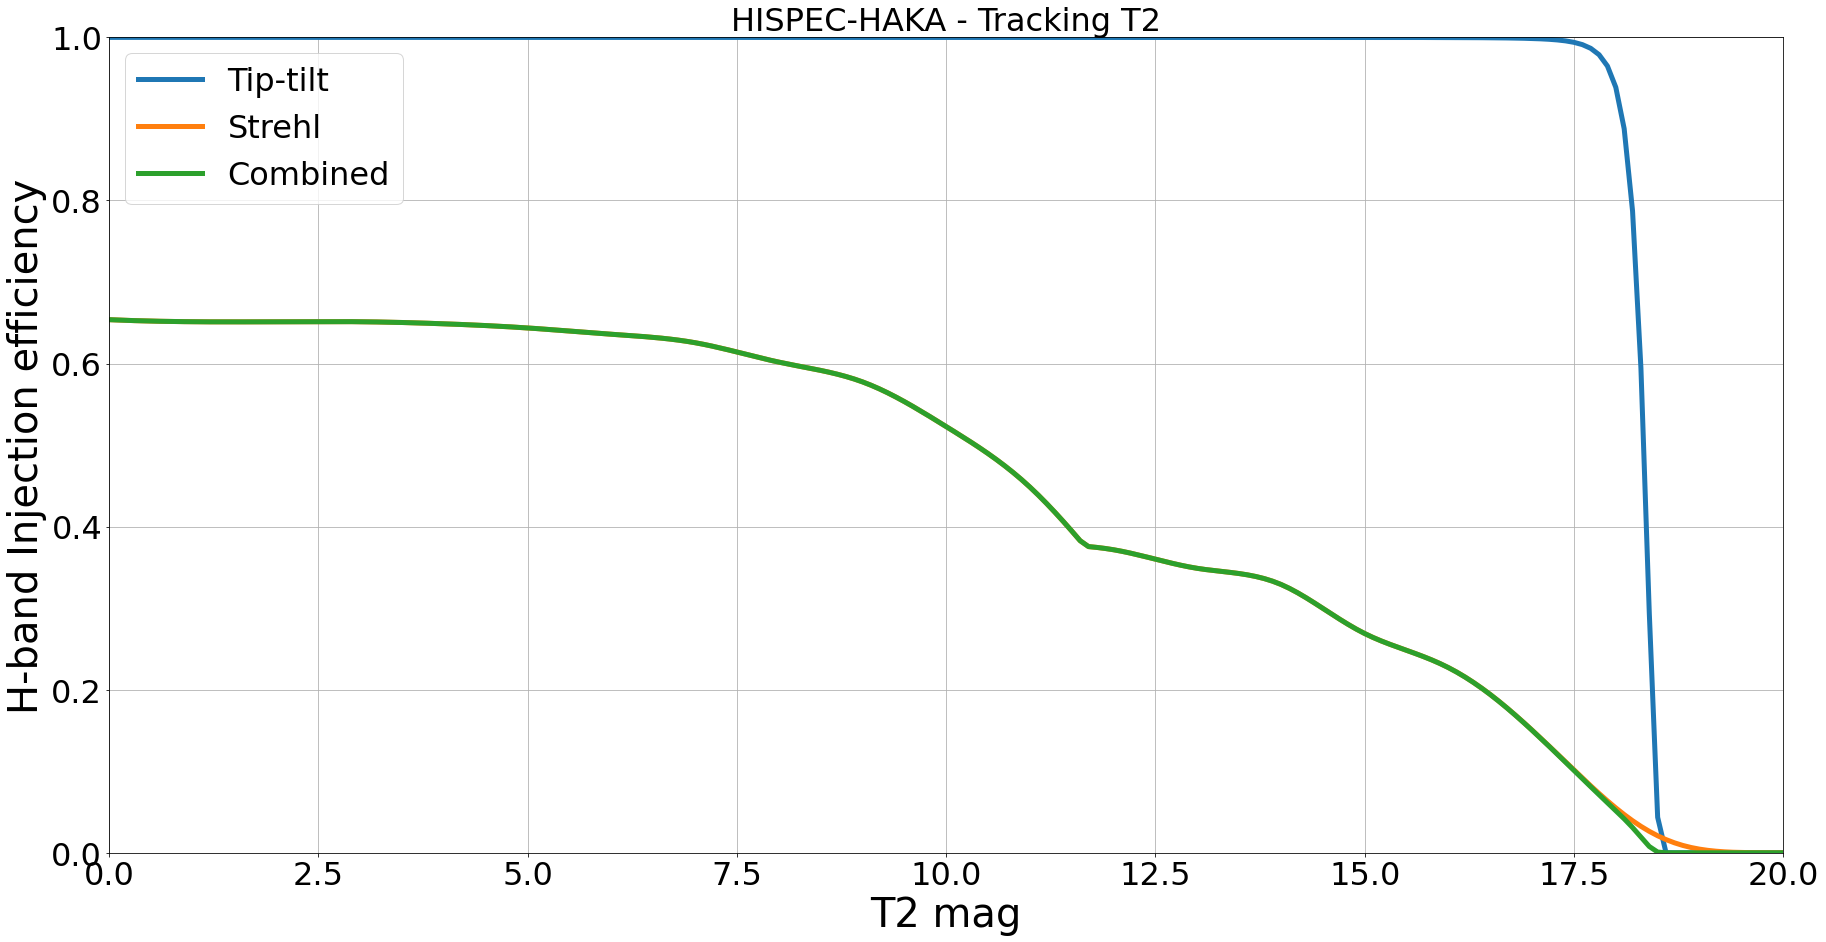

In [86]:
plt.figure(figsize=(30,15))
plt.plot(mag_fine, eff_tt, linewidth=5, label='Tip-tilt')
plt.plot(mag_fine, eff, linewidth=5, label='Strehl')
plt.plot(mag_fine, eff*eff_tt, linewidth=5, label='Combined')

plt.xlabel('T2 mag')
plt.ylabel('H-band Injection efficiency')
plt.title('HISPEC-HAKA - Tracking T2')
plt.legend()

plt.ylim([0,1])
plt.xlim([0,20])
plt.grid()

## HAKA (visible SH WFS) - J band

In [87]:
f_ngs = interp1d(mag,aowfe_ngs,kind='cubic')
f_lgs = interp1d(mag,aowfe_lgs,kind='cubic')

aowfe_ngs_interp=f_ngs(mag_fine)
aowfe_lgs_interp=f_lgs(mag_fine)

res = np.zeros(len(mag_fine))
t_10sigma =  np.zeros(len(mag_fine))
eff_tt =  np.zeros(len(mag_fine))
eff =  np.zeros(len(mag_fine))

for i in range(len(mag_fine)):
    aowfe_interp = np.min([aowfe_ngs_interp[i],aowfe_lgs_interp[i]])
    strehl = np.exp(-(2*np.pi*aowfe_interp/j_wv)**2)
    strehl_t2 = np.exp(-(2*np.pi*aowfe_interp/t2_wv)**2)
    flux = h_fl * th * area * bw * strehl_t2 * 10**(-0.4*mag_fine[i])
    dc_tot_flux = dc * samp 
    fps = np.max([(flux/samp + dc_tot_flux/samp)/sat,1/tmax])
    t = 1.0/fps
    print('fps',fps, 'tint',t)
    signal = flux * t
    dc_tot = dc_tot_flux * t
    ron_tot = samp * ron**2 
    noise = np.sqrt(signal + dc_tot + ron_tot)
    res[i] = t2_wv * 1e-9/diam * 206265 * 1.0/strehl_t2**0.25 / (signal / noise)
    eff_tt[i] = np.exp(-(res[i]/(0.6*j_wv * 1e-9/diam * 206265))**2)
    eff[i]=strehl*0.65*1.3

fps 20351.457351551 tint 4.9136530260511754e-05
fps 18543.727536101924 tint 5.392659043620795e-05
fps 16898.20723103468 tint 5.917787528155256e-05
fps 15400.126976402273 tint 6.493452953552314e-05
fps 14036.086212365422 tint 7.124493144812878e-05
fps 12793.923967590614 tint 7.816210277106428e-05
fps 11662.601984099687 tint 8.574415909617417e-05
fps 10632.099065071172 tint 9.405480459500459e-05
fps 9693.315551527146 tint 0.00010316387562999057
fps 8837.986941517447 tint 0.00011314793816931167
fps 8058.6057624775385 tint 0.0001240909444480083
fps 7348.35089492349 tint 0.00013608495488298423
fps 6701.0236244939115 tint 0.00014923093187505724
fps 6110.989770402525 tint 0.00016363961282398463
fps 5573.127302392688 tint 0.00017943247044988083
fps 5082.778915979267 tint 0.00019674276936504058
fps 4635.709087749039 tint 0.00021571672878324856
fps 4228.065179333116 tint 0.00023651480229964854
fps 3856.342200873124 tint 0.0002593130868348736
fps 3517.3508828362833 tint 0.00028430487412550406
fps

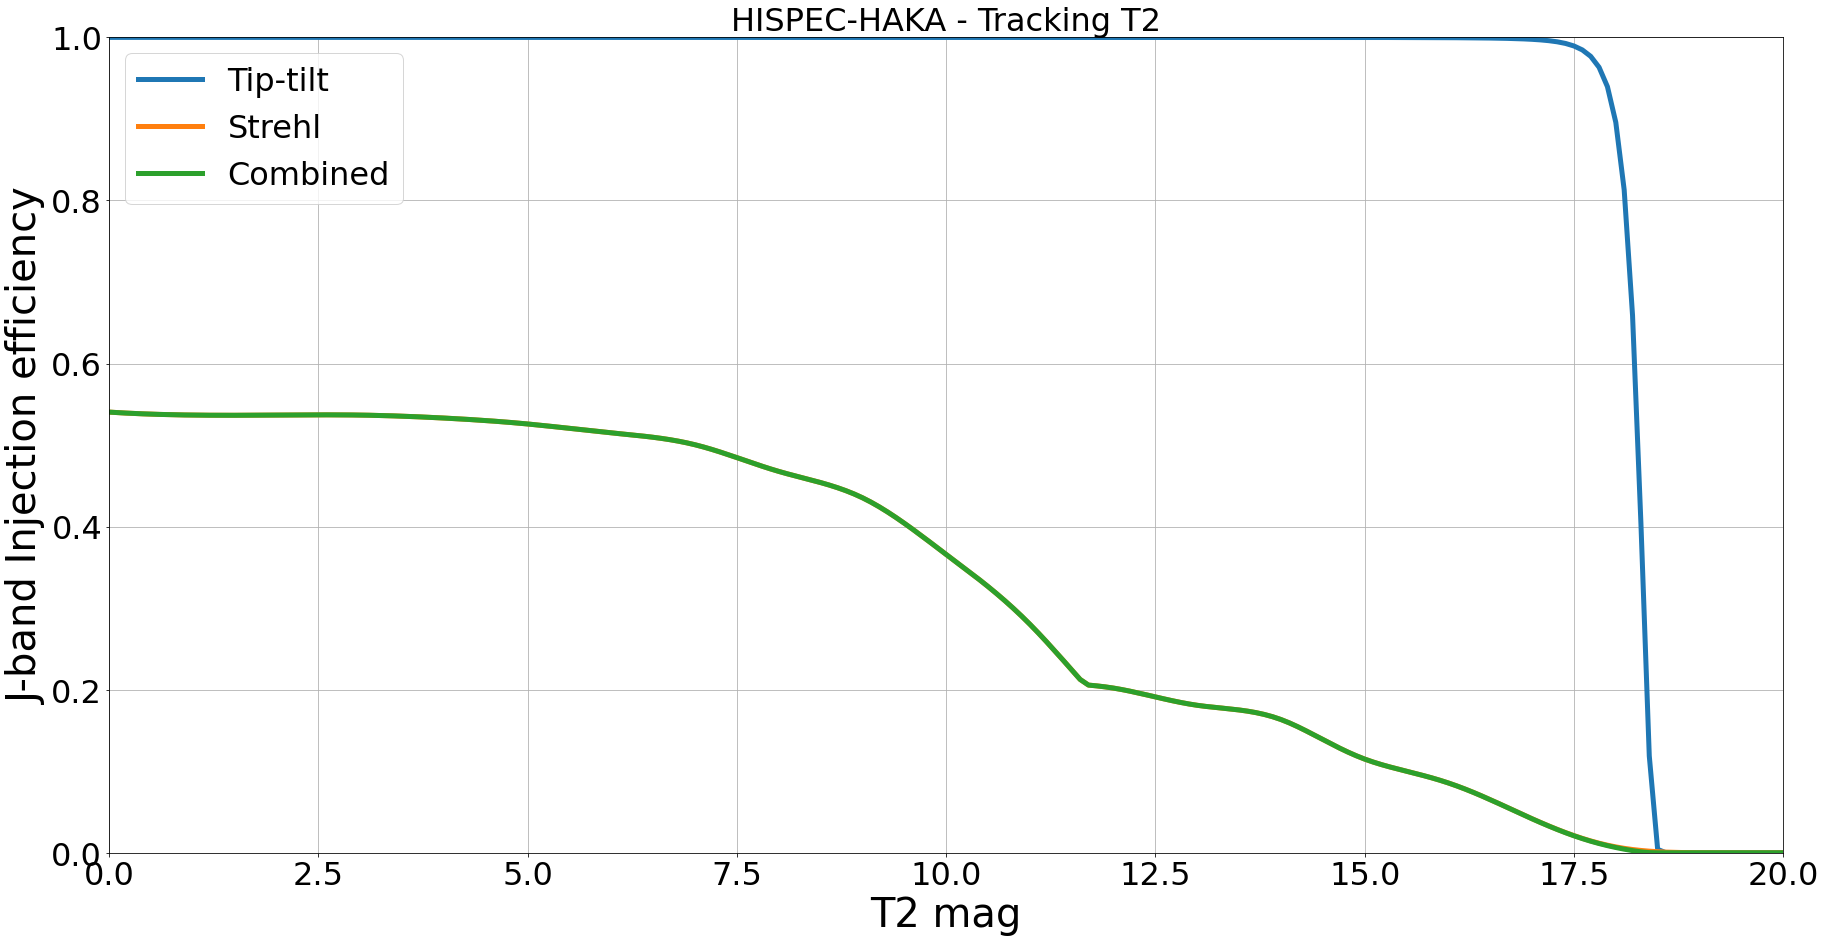

In [88]:
plt.figure(figsize=(30,15))
plt.plot(mag_fine, eff_tt, linewidth=5, label='Tip-tilt')
plt.plot(mag_fine, eff, linewidth=5, label='Strehl')
plt.plot(mag_fine, eff*eff_tt, linewidth=5, label='Combined')

plt.xlabel('T2 mag')
plt.ylabel('J-band Injection efficiency')
plt.title('HISPEC-HAKA - Tracking T2')
plt.legend()

plt.ylim([0,1])
plt.xlim([0,20])
plt.grid()

## HAKA (visible SH WFS) - y band

In [89]:
f_ngs = interp1d(mag,aowfe_ngs,kind='cubic')
f_lgs = interp1d(mag,aowfe_lgs,kind='cubic')

aowfe_ngs_interp=f_ngs(mag_fine)
aowfe_lgs_interp=f_lgs(mag_fine)

res = np.zeros(len(mag_fine))
t_10sigma =  np.zeros(len(mag_fine))
eff_tt =  np.zeros(len(mag_fine))
eff =  np.zeros(len(mag_fine))

for i in range(len(mag_fine)):
    aowfe_interp = np.min([aowfe_ngs_interp[i],aowfe_lgs_interp[i]])
    strehl = np.exp(-(2*np.pi*aowfe_interp/y_wv)**2)
    strehl_t2 = np.exp(-(2*np.pi*aowfe_interp/t2_wv)**2)
    flux = h_fl * th * area * bw * strehl_t2 * 10**(-0.4*mag_fine[i])
    dc_tot_flux = dc * samp 
    fps = np.max([(flux/samp + dc_tot_flux/samp)/sat,1/tmax])
    t = 1.0/fps
    print('fps',fps, 'tint',t)
    signal = flux * t
    dc_tot = dc_tot_flux * t
    ron_tot = samp * ron**2 
    noise = np.sqrt(signal + dc_tot + ron_tot)
    res[i] = t2_wv * 1e-9/diam * 206265 * 1.0/strehl_t2**0.25 / (signal / noise)
    eff_tt[i] = np.exp(-(res[i]/(0.6*y_wv * 1e-9/diam * 206265))**2)
    eff[i]=strehl*0.65*1.3

fps 20351.457351551 tint 4.9136530260511754e-05
fps 18543.727536101924 tint 5.392659043620795e-05
fps 16898.20723103468 tint 5.917787528155256e-05
fps 15400.126976402273 tint 6.493452953552314e-05
fps 14036.086212365422 tint 7.124493144812878e-05
fps 12793.923967590614 tint 7.816210277106428e-05
fps 11662.601984099687 tint 8.574415909617417e-05
fps 10632.099065071172 tint 9.405480459500459e-05
fps 9693.315551527146 tint 0.00010316387562999057
fps 8837.986941517447 tint 0.00011314793816931167
fps 8058.6057624775385 tint 0.0001240909444480083
fps 7348.35089492349 tint 0.00013608495488298423
fps 6701.0236244939115 tint 0.00014923093187505724
fps 6110.989770402525 tint 0.00016363961282398463
fps 5573.127302392688 tint 0.00017943247044988083
fps 5082.778915979267 tint 0.00019674276936504058
fps 4635.709087749039 tint 0.00021571672878324856
fps 4228.065179333116 tint 0.00023651480229964854
fps 3856.342200873124 tint 0.0002593130868348736
fps 3517.3508828362833 tint 0.00028430487412550406
fps

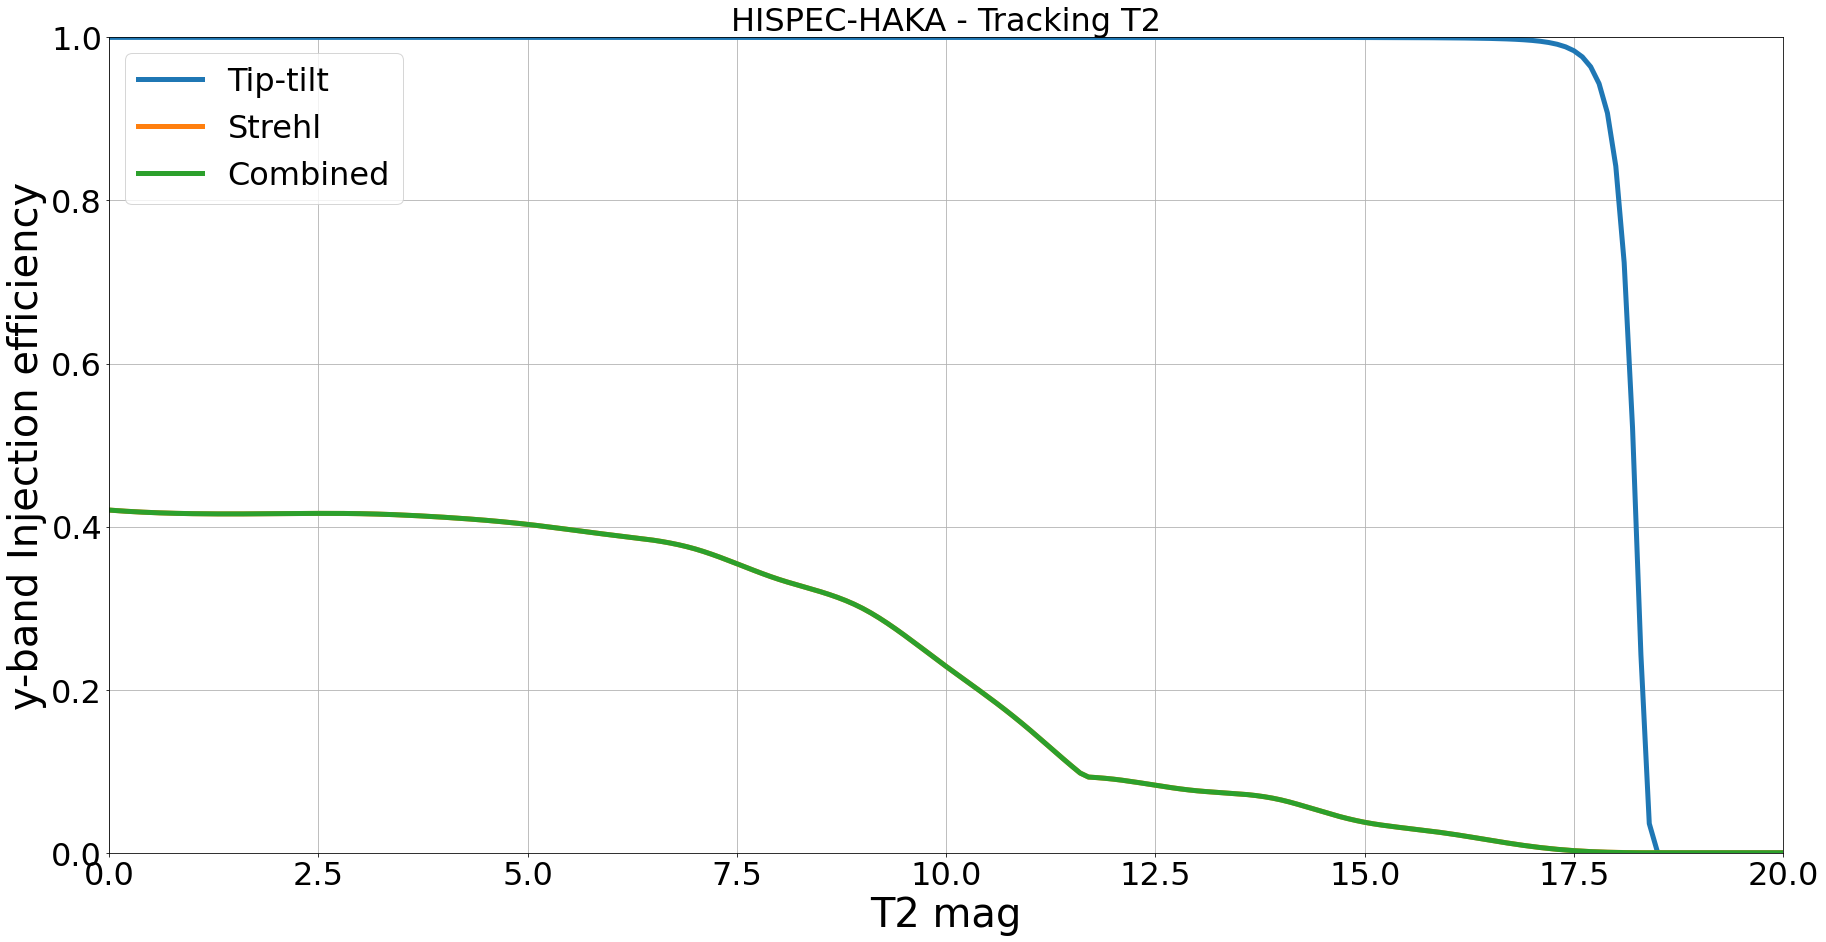

In [90]:
plt.figure(figsize=(30,15))
plt.plot(mag_fine, eff_tt, linewidth=5, label='Tip-tilt')
plt.plot(mag_fine, eff, linewidth=5, label='Strehl')
plt.plot(mag_fine, eff*eff_tt, linewidth=5, label='Combined')

plt.xlabel('T2 mag')
plt.ylabel('y-band Injection efficiency')
plt.title('HISPEC-HAKA - Tracking T2')
plt.legend()

plt.ylim([0,1])
plt.xlim([0,20])
plt.grid()